In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
import tensorflow as tf
#import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import os
os.environ["KERAS_BACKEND"] = "tensorflow" 

import keras
import keras_nlp

import tensorflow as tf

import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import plotly.graph_objs as go
import plotly.express as px

2024-08-03 16:53:05.067132: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-03 16:53:05.067292: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-03 16:53:05.219759: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

TensorFlow version: 2.15.0
KerasNLP version: 0.14.0


In [3]:
model_type="distil_bert_base_en_uncased"

In [4]:
# reading train data
train_data_path = "/kaggle/input/nlp-getting-started/train.csv"

# Load data from CSV file into a DataFrame
train_data = pd.read_csv(train_data_path)

train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Split data into training and test sets (80% train, 20% test)
train_data, test_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Define a function to parse the DataFrame
def parse_dataframe(df):
    # Return features (text review) and labels (sentiment label)
    return df["text"].values, df["target"].values

# Convert training and test data to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(parse_dataframe(train_data)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices(parse_dataframe(test_data)).batch(32)

In [6]:
tokenizer = keras_nlp.models.DistilBertTokenizer.from_preset(model_type)
backbone = keras_nlp.models.DistilBertBackbone.from_preset(model_type)

Attaching 'model.safetensors' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'model.safetensors.index.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.txt' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'model.safetensors' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook.

In [7]:
packer = keras_nlp.layers.MultiSegmentPacker(
    start_value=tokenizer.cls_token_id,
    end_value=tokenizer.sep_token_id,
    pad_value=tokenizer.pad_token_id,
    sequence_length=500
)

def preprocess(x, y):
    token_ids, _ = packer(tokenizer(x))
    x = {
        "token_ids": token_ids,
        "padding_mask": token_ids != tokenizer.pad_token_id,
    }
    return x, y

train_ds = train_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = test_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

In [8]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=3, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [9]:
inputs = backbone.input
outputs = backbone(inputs)[:, 0, :]
#outputs = keras.layers.Dense(2028,activation='relu')(outputs)
outputs = keras.layers.Dense(1024,activation='relu')(outputs)
outputs = keras.layers.Dense(512,activation='relu')(outputs)
outputs = keras.layers.Dense(256, activation='relu')(outputs)
outputs = keras.layers.Dense(128,activation='relu')(outputs)

outputs = keras.layers.Dropout(0.1)(outputs)

outputs = keras.layers.Dense(2)(outputs)
    
model = keras.Model(inputs, outputs)
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(1e-5),
     metrics= ["accuracy"],
    jit_compile=True,
    
)

history=model.fit(train_ds, validation_data=val_ds,epochs=2)

Epoch 1/2


I0000 00:00:1722704059.330596      58 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-08-03 16:54:19.353554: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


215/215 ━━━━━━━━━━━━━━━━━━━━ 11449s 53s/step - accuracy: 0.7501 - loss: 0.5268 - val_accuracy: 0.8360 - val_loss: 0.3966
Epoch 2/2
215/215 ━━━━━━━━━━━━━━━━━━━━ 11333s 53s/step - accuracy: 0.8506 - loss: 0.3726 - val_accuracy: 0.8360 - val_loss: 0.3920


Minimum validation loss: 0.39198264479637146


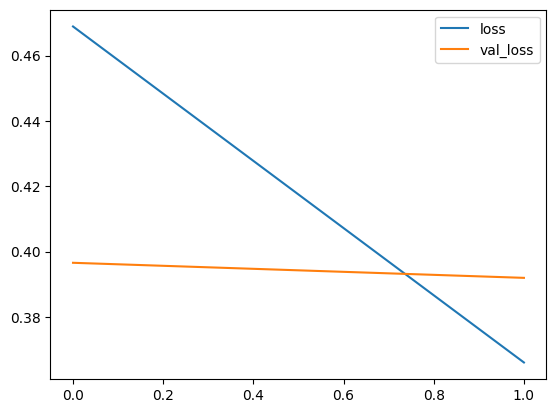

In [10]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

In [11]:
# reading train data
test_data_path = "/kaggle/input/nlp-getting-started/test.csv"

# Load data from CSV file into a DataFrame
test_data = pd.read_csv(test_data_path)

test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [12]:
# Define a function to parse the DataFrame
def parse_dataframe(df):
    # Return only features (text review)
    return df["text"].values

# Convert test data to TensorFlow dataset
test_dataset = tf.data.Dataset.from_tensor_slices(parse_dataframe(test_data)).batch(28)

# Define the preprocess function
def preprocess(x):
    token_ids, _ = packer(tokenizer(x))
    x = {
        "token_ids": token_ids,
        "padding_mask": token_ids != tokenizer.pad_token_id,
    }
    return x

# Map the preprocess function to the test dataset
test_ds = test_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

In [13]:
#test_ds = tf.data.Dataset.from_tensor_slices((test_data["text"]).values).batch(28)
#test_ids = tf.data.Dataset.from_tensor_slices((test_data["id"]).values).batch(28)

In [14]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [15]:
#predictions = model.predict(test_ds)
sample_submission["target"] = np.argmax( model.predict(test_ds), axis=1)

117/117 ━━━━━━━━━━━━━━━━━━━━ 1404s 12s/step


In [16]:
sample_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [17]:
sample_submission.describe()

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.373583
std,3146.427221,0.483829
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


In [18]:
sample_submission.to_csv("submission.csv", index=False)